# Aprendizaje Automático: Trabajo Práctico 1 

* Alumnxs: Facundo Garcia, Trinidad Borrell
* Octubre 2024

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from scipy.stats import pointbiserialr

In [3]:
COLOR = "black"
%config InlineBackend.figure_format = "retina"  
plt.rcParams["figure.dpi"] = 50
plt.rcParams["figure.figsize"] = (21, 8)

plt.rcParams["font.family"] = "serif"
plt.rcParams["mathtext.fontset"] = "cm"

plt.rcParams["figure.dpi"] = 50
plt.rcParams["axes.grid"] = True
plt.rcParams["legend.fontsize"] = 18
plt.rcParams['legend.title_fontsize'] = 21  
plt.rcParams["axes.titlesize"] = 25
plt.rcParams["axes.labelsize"] = 21
plt.rcParams["ytick.labelsize"] = 18
plt.rcParams["xtick.labelsize"] = 18

plt.rcParams["axes.grid"] = True

plt.rcParams["text.color"] = COLOR
plt.rcParams["text.color"] = COLOR
plt.rcParams["axes.labelcolor"] = COLOR
plt.rcParams["xtick.color"] = COLOR
plt.rcParams["ytick.color"] = COLOR
plt.rcParams["grid.color"] = COLOR
plt.rcParams["text.latex.preamble"] = "\n".join([r"\usepackage[version=3]{mhchem}"])

# Ejercicio 1

A continuación cargamos los datos

In [12]:
df = pd.read_csv("data.csv")
display(df.head(5))
print(df.shape)

,IMzq,NuAg,FpJw,vilF,AKmi,BDfC,pDDY,znPg,VNds,eCei,...,kcQL,OHJK,zbGt,XzTy,uauW,xbpG,Nozi,jRec,MngL,target
0,-6.774862,0.732090,0.500918,0.944929,-0.602723,1.032872,6.064671,-1.569083,-0.433074,-0.411138,...,3.875406,5.014296,0.302964,-0.719671,1.771007,-38.327154,-1.016544,-0.910132,-4.412012,0
1,3.857655,-0.612246,0.618588,0.459552,0.784440,-0.468198,0.651061,-4.741020,-0.552092,-5.488178,...,-3.830493,-3.467904,0.938938,-2.063109,0.179054,-11.194070,-5.197824,-0.286773,21.186963,1
2,-4.350896,0.654858,-0.424538,0.400425,-0.695568,0.954559,0.381870,1.490369,-1.097865,8.438625,...,2.430782,3.176884,1.521718,1.066505,-1.413488,10.341004,-4.757295,1.043693,-13.073736,0
3,-0.661896,-0.047801,0.025763,0.396485,-0.789812,-1.025823,2.003485,-2.794396,0.416429,3.011011,...,-3.220567,6.810913,1.641394,-0.715173,-0.041199,16.963959,-5.634772,1.736776,15.345755,0
4,1.596179,2.670130,0.961231,-0.337469,0.422516,-1.507684,3.563408,0.461990,-0.298087,-1.129244,...,0.721628,-1.546083,0.020279,1.458865,0.887693,15.078228,-3.548321,1.544351,6.419401,0


(500, 201)


Para adentrarnos más en cómo es nuestro dataset comenzamos viendo la distribución de etiquetas.

Cociente entre buen pronostico y mal pronostico: 0.34408602150537637


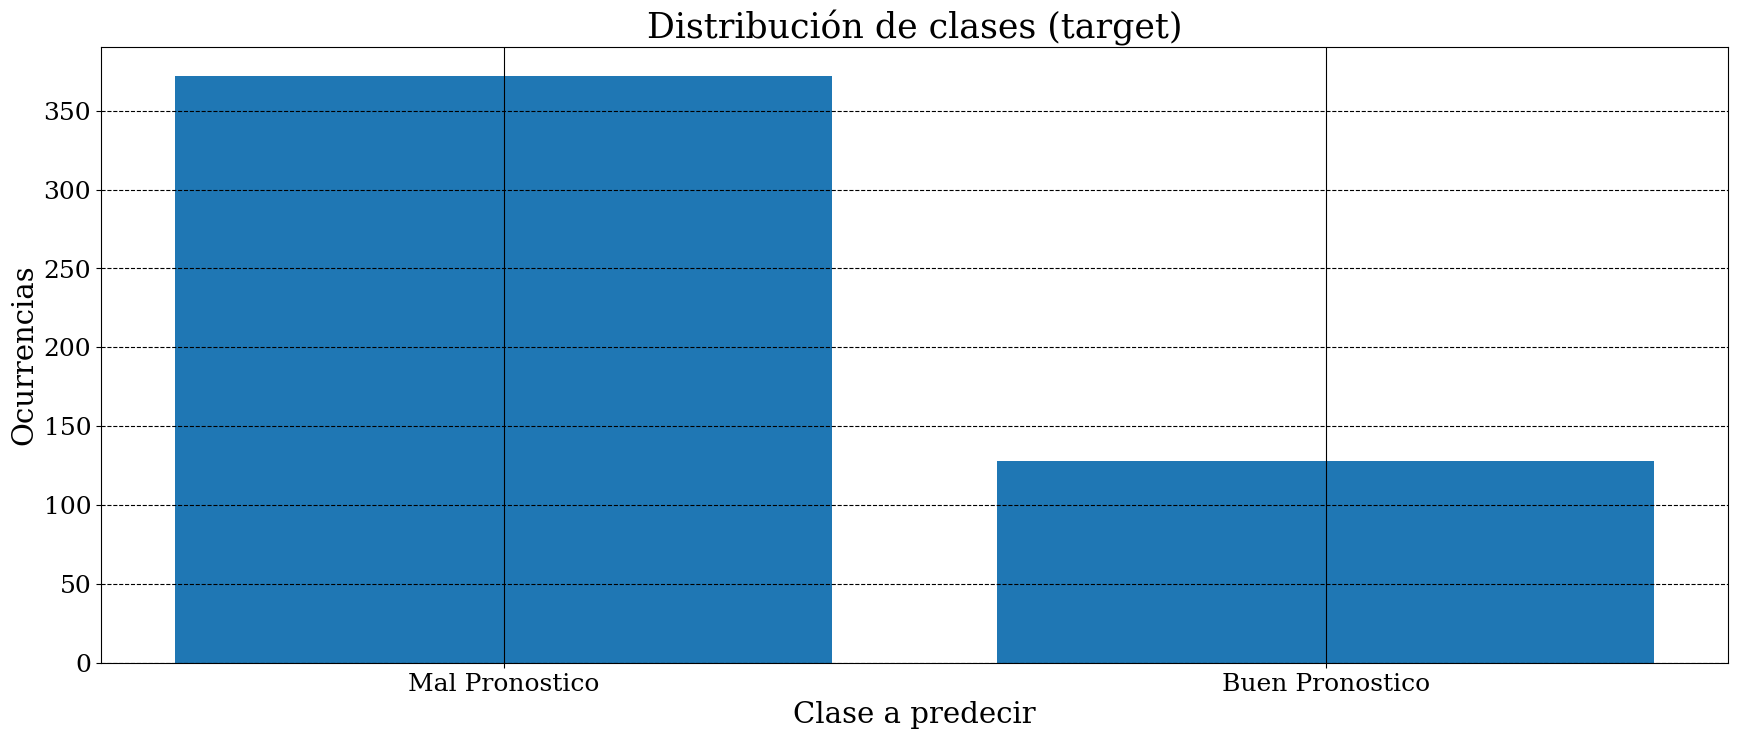

In [16]:
count_target = df.groupby("target")[df.columns[0]].count().to_dict()

plt.bar(count_target.keys(), count_target.values())
plt.xticks([0, 1], labels = ['Mal Pronostico', 'Buen Pronostico'])
plt.ylabel("Ocurrencias")
plt.xlabel("Clase a predecir")
plt.grid(ls="--", axis="y")
plt.title("Distribución de clases (target)")

print(f'Cociente entre buen pronostico y mal pronostico: {count_target[1] / count_target[0]}')

Separamos el set de desarrollo (exclusivo para entrenamiento) y evaluación (exclusivo para testeo) mediante un split estratrificado, manteniendo la proporción de positivos y negativos. El set de evaluación servirá para poder determinar con mayor precisión la performance de los modelos.

In [21]:
def stratified_sampling(
        df: pd.DataFrame,
        train_frac: float = 0.8
    ) -> tuple[pd.DataFrame, pd.DataFrame]:
    """
    Obtener el set de entrenamiento y testeo asegurandose
    que se respeta la proporción entre positivos y negativos
    tanto en el set de entrenamiento como en testeo.
    """

    # Contamos cuantas instancias de cada tipo hay
    count_target = df.groupby("target")[df.columns[0]].count().to_dict()

    # Calculamos cuantas instancias de entrenamiento vamos a usar
    count_target_train = {0: count_target[0] * train_frac,
                          1: count_target[1] * train_frac}

    # Nos quedamos con los N elementos calculados por cada clase
    pos_train_df = df[df["target"] == 1].sample(n=int(count_target_train[1]), random_state=42)
    neg_train_df = df[df["target"] == 0].sample(n=int(count_target_train[0]), random_state=42)

    # Concatenamos los dos y los mezclamos para que no haya problemas de ordenamiento
    train_df = pd.concat([pos_train_df, neg_train_df]).sample(frac=1, random_state = 42)

    # Eliminamos las instancias de training sobre el total para tener el df de testeo
    test_df = df.drop(train_df.index)

    return train_df, test_df

train_set, test_set = stratified_sampling(df, train_frac=0.9)

count_target_df = df.groupby("target")[df.columns[0]].count().to_dict()
print("# Clase 1 / # Clase 0 en total:", round(count_target_df[1] / count_target_df[0], 3))

count_target_train = train_set.groupby("target")[train_set.columns[0]].count().to_dict()
print("# Clase 1 / # Clase 0 en Train:", round(count_target_train[1] / count_target_train[0], 3))

count_target_test = test_set.groupby("target")[test_set.columns[0]].count().to_dict()
print("# Clase 1 / # Clase 0 en Test:", round(count_target_test[1] / count_target_test[0], 3))

# Clase 1 / # Clase 0 en total: 0.344
# Clase 1 / # Clase 0 en Train: 0.344
# Clase 1 / # Clase 0 en Test: 0.342


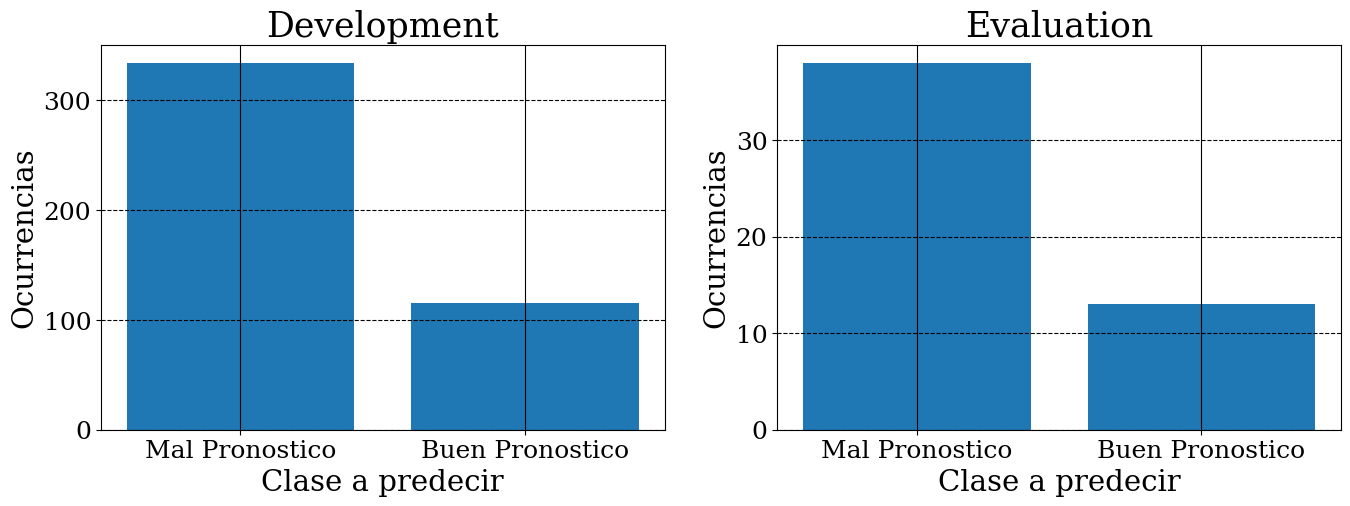

In [18]:
fig, ax = plt.subplots(1, 2, figsize=(16, 5))

ax[0].bar(count_target.keys(), count_target_train.values())
ax[0].set_xticks([0, 1], labels = ['Mal Pronostico', 'Buen Pronostico'])
ax[0].set_ylabel("Ocurrencias")
ax[0].set_xlabel("Clase a predecir")
ax[0].grid(ls="--", axis="y")
ax[0].set_title("Development")

count_target_test = test_set.groupby("target")[test_set.columns[0]].count().to_dict()

ax[1].bar(count_target.keys(), count_target_test.values())
ax[1].set_xticks([0, 1], labels = ['Mal Pronostico', 'Buen Pronostico'])
ax[1].set_ylabel("Ocurrencias")
ax[1].set_xlabel("Clase a predecir")
ax[1].grid(ls="--", axis="y")
ax[1].set_title("Evaluation")

plt.show()

Finalmente separamos el array de etiquetas de las features para cada instancia.

In [22]:
X_train, y_train = train_set.drop("target", axis=1), train_set["target"]
X_test, y_test = test_set.drop("target", axis=1), test_set["target"]

# Ejercicio 2

In [26]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, precision_recall_curve, auc

Definimos una función auxiliar para calcular el area bajo la curva de Precision - Recall.

In [31]:
def auprc(y_true: np.ndarray, pred_probas: np.ndarray):
    """
    Calcular Area Under Precision Recall Curve (AUPRC).
    """

    precision, recall, _ = precision_recall_curve(y_true, pred_probas)
    return auc(recall, precision)

## 2.1 Entrenamiento de un arbol sencillo

Entrenamos un arbol de profundidad 3 y vemos rapidamente como dan las metricas. Para eso usamos el set de evaluación, teniendo en cuenta que nuestro Pipeline "terminaría aquí" (siguiendo las consignas del ejercicio).

In [32]:
tree = DecisionTreeClassifier(random_state=42, max_depth=3)
tree.fit(X=X_train, y=y_train)
y_pred_train = tree.predict(X_train)
y_probas_train = tree.predict_proba(X_train)

y_pred = tree.predict(X_test)
y_probas = tree.predict_proba(X_test)

print(f"Accuracy (Train): {accuracy_score(y_train, y_pred_train):.3f}")
print(f"Precision (Train): {precision_score(y_train, y_pred_train):.3f}")
print(f"Recall (Train): {recall_score(y_train, y_pred_train):.3f}")
print(f"ROC AUC (Train): {roc_auc_score(y_train, y_probas_train[:, 1]):.3f}")
print(f"AUPRC (Train): {auprc(y_train, y_probas_train[:, 1]):.3f}")
print()
print(f"Accuracy (Test): {accuracy_score(y_test, y_pred):.3f}")
print(f"Precision (Test): {precision_score(y_test, y_pred):.3f}")
print(f"Recall (Test): {recall_score(y_test, y_pred):.3f}")
print(f"ROC AUC (Test): {roc_auc_score(y_test, y_probas[:, 1]):.3f}")
print(f"AUPRC (Test): {auprc(y_test, y_probas[:, 1]):.3f}")

Accuracy (Train): 0.835
Precision (Train): 0.720
Recall (Train): 0.583
ROC AUC (Train): 0.819
AUPRC (Train): 0.708

Accuracy (Test): 0.745
Precision (Test): 0.500
Recall (Test): 0.538
ROC AUC (Test): 0.784
AUPRC (Test): 0.685


Se observa que el modelo realiza un overfitting, ya que las cinco métricas analizadas muestran valores más bajos al probarse en el conjunto de evaluación.

## 2.2 K-fold Cross Validation

Definimos una función previa a implementar _cross validation_ que nos permita generar _K-folds_ de manera estratificada (manteniendo la relación de positivos / negativos).

In [28]:
def stratified_sampling_kfolds(
    X: np.ndarray, 
    y: np.ndarray, 
    num_folds: int = 5
) -> list:
    """
    Realiza un muestreo estratificado para dividir el dataset en k-folds,
    preservando la proporción de clases del target `y` (para el caso de un target binario).
    
    Parámetros:
    -----------
    X: np.ndarray
        Matriz de características (features) del conjunto de datos.
    y: np.ndarray
        Vector objetivo (target) binario, donde 0 y 1 son las clases.
    num_folds: int, opcional (default=5)
        Número de folds (particiones) en los que se desea dividir el conjunto de datos.

    Retorna:
    --------
    folds: list
        Lista de tuplas donde cada tupla contiene dos elementos:
        - El primer elemento es el conjunto de características para el fold.
        - El segundo elemento es el conjunto de etiquetas para el fold.
    """
    
    # Inicializar listas para almacenar los folds
    folds = []

    # Obtener los índices de las clases positivas y negativas
    pos_idx = np.where(y == 1)[0].tolist()
    neg_idx = np.where(y == 0)[0].tolist()

    # Barajar los índices para mezclar los datos
    np.random.seed(42)
    np.random.shuffle(pos_idx)
    np.random.shuffle(neg_idx)

    # Calcular el tamaño de cada fold de validación para las clases positivas y negativas
    num_pos = len(pos_idx) // num_folds
    num_neg = len(neg_idx) // num_folds

    # Crear los folds distribuyendo los índices de manera estratificada
    for i in range(num_folds):
        # Obtener indices para la clase positiva y negativa
        pos_fold_idx = pos_idx[i * num_pos : (i + 1) * num_pos]
        neg_fold_idx = neg_idx[i * num_neg : (i + 1) * num_neg]

        val_fold_idx = np.concatenate([pos_fold_idx, neg_fold_idx])
        train_fold_idx = np.setdiff1d(np.arange(len(y)), val_fold_idx)

        X_val_fold = X.iloc[val_fold_idx]
        y_val_fold = y.iloc[val_fold_idx]

        X_train_fold = X.iloc[train_fold_idx]        
        y_train_fold = y.iloc[train_fold_idx]
        
        folds.append((X_train_fold, y_train_fold, X_val_fold, y_val_fold))

    return folds

A continuación, implementamos _K-Fold Cross Validation_ definiendo las siguientes funciones. 

La función principal, **cross_val**, utiliza **train_and_evaluate_model** para generar las predicciones y calcular las métricas correspondientes de cada _k-fold_. Finalmente, devuelve tanto los resultados globales como los de cada _fold_ individual. Además, defninimos la función **select_relevant_features** que permite al usuario realizar los entrenamientos empleando solo las features más relevantes para cada _k-fold_.


In [29]:
def select_relevant_features(X_train_fold, y_train_fold, num_features: int) -> np.ndarray:
    """
    Selecciona las features más relevantes basadas en la correlación punto-biserial con el target.

    Args:
        X_train_fold (np.ndarray): Subconjunto de entrenamiento de las características.
        y_train_fold (np.ndarray): Subconjunto de entrenamiento del target.
        num_features (int): Número de features a seleccionar.

    Returns:
        np.ndarray: Subconjunto reducido de características importantes.
    """
    correlations = [
        (c, abs(pointbiserialr(y_train_fold, X_train_fold[c]).statistic)) 
        for c in X_train_fold.columns]

    sorted_correlations = sorted(correlations, key=lambda x: x[1], reverse=True)
    important_features = [c[0] for c in sorted_correlations[:num_features]]

    return important_features


def train_and_evaluate_model(model, params, X_train, y_train, X_val, y_val):
    """
    Entrena un modelo con los datos de entrenamiento y calcula las métricas de validación.

    Args:
        model: El modelo que se va a entrenar.
        params (Dict[str, Any]): Parámetros para instanciar el modelo.
        X_train (np.ndarray): Subconjunto de entrenamiento de características.
        y_train (np.ndarray): Subconjunto de entrenamiento del target.
        X_val (np.ndarray): Subconjunto de validación de características.
        y_val (np.ndarray): Subconjunto de validación del target.

    Returns:
        Dict: Métricas calculadas para el fold actual.
        np.ndarray: Predicciones para el fold de validación.
        np.ndarray: Probabilidades para el fold de validación.
    """
    # Instanciar y entrenar el modelo
    model_instance = model(**params)
    model_instance.fit(X_train, y_train)

    # Predecir probabilidades y clases
    y_train_probas = model_instance.predict_proba(X_train)[:, 1]
    y_train_pred = model_instance.predict(X_train)

    y_val_probas = model_instance.predict_proba(X_val)[:, 1]
    y_val_pred = model_instance.predict(X_val)

    # Calcular métricas de validación
    val_accuracy = accuracy_score(y_val, y_val_pred)
    val_rocauc = roc_auc_score(y_val, y_val_probas)
    val_auprc = auprc(y_val, y_val_probas)

    train_accuracy = accuracy_score(y_train, y_train_pred)
    train_rocauc = roc_auc_score(y_train, y_train_probas)
    train_auprc = auprc(y_train, y_train_probas)

    # Guardar las métricas
    scores = {
        "Train Accuracy": train_accuracy,
        "Train ROC AUC": train_rocauc,
        "Train AUPRC": train_auprc,

        "Validation Accuracy": val_accuracy,
        "Validation ROC AUC": val_rocauc,
        "Validation AUPRC": val_auprc
    }

    return scores, y_val_pred, y_val_probas


def cross_val(X, y, model, params: dict[str, any], cv: int = 5, relevant_features: bool = False, num_features: int = 25) -> list[float]:
    """
    Implementa K-fold cross-validation para un modelo sin utilizar Scikit-learn.

    Args:
        dataset (pd.DataFrame): Dataset de entrenamiento (features + target).
        model: El modelo que se va a entrenar.
        params (Dict[str, Any]): Parámetros del modelo.
        cv (int): Número de folds para cross-validation.
        relevant_features (bool): Si se seleccionan las features más correlacionadas en cada fold.
        num_features (int): Número de features con las que quedarse si `relevant_features` es True.
        preserve_proportion (bool): Si se preserva la proporción de positivos/negativos en cada fold.

    Returns:
        scores (list): Lista con métricas de validación por fold.
        global_results (tuple): Métricas globales (accuracy, ROC AUC, AUPRC) sobre todo el dataset.
    """
    np.random.seed(42)

    # Crear los K folds
    folds = stratified_sampling_kfolds(X, y, num_folds=cv)

    scores = []
    y_predicted_total = []
    y_proba_total = []
    y_true_total = []

    already_validated = set()

    for i, (X_train_fold, y_train_fold, X_val_fold, y_val_fold) in enumerate(folds):
        
        # Validar que no hay instancias repetidas entre validación y train
        assert len(set(y_val_fold.index).union(set(y_train_fold.index))) == len(y_val_fold) + len(y_train_fold)

        # Validar que la instancia de validación se usa una sola vez
        len_should_have = len(already_validated) + len(y_val_fold)
        already_validated = already_validated.union(y_val_fold.index)
        assert len_should_have == len(already_validated)

        # Seleccionar features relevantes si es necesario
        if relevant_features:
            important_features = select_relevant_features(X_train_fold, y_train_fold, num_features)
            X_train_fold = X_train_fold[important_features]
            X_val_fold = X_val_fold[important_features]

        # Entrenar el modelo y evaluar el fold
        fold_scores, y_val_pred, y_val_probas = train_and_evaluate_model(model, params, X_train_fold, y_train_fold, X_val_fold, y_val_fold)

        # Guardar predicciones y probabilidades para cálculos globales
        y_predicted_total.extend(y_val_pred)
        y_proba_total.extend(y_val_probas)
        y_true_total.extend(y_val_fold)

        # Guardar las métricas del fold
        fold_scores["Fold"] = i + 1
        scores.append(fold_scores)

    # Calcular métricas globales
    global_acc = accuracy_score(y_true_total, y_predicted_total)
    global_rocauc = roc_auc_score(y_true_total, y_proba_total)
    global_auprc = auprc(y_true_total, y_proba_total)

    global_results = (global_acc, global_rocauc, global_auprc)

    return scores, global_results

In [33]:
results, global_results = cross_val(X_train, y_train, DecisionTreeClassifier, {"random_state": 42, "max_depth": 3}, cv=5, relevant_features=False)
acc_global, rocauc_global, auprc_global = global_results
results = pd.DataFrame(results)
results = results[['Fold', 'Train Accuracy', 'Validation Accuracy', 'Train ROC AUC', 'Validation ROC AUC', 'Train AUPRC', 'Validation AUPRC']]

mean_results = pd.DataFrame(results.mean()).T
mean_results["Fold"] = "Promedio"
results = pd.concat([results, mean_results]).reset_index(drop=True)
results.loc[len(results.index)] = ['Global','(NO)', acc_global, '(NO)', rocauc_global, '(NO)', auprc_global] 

results

,Fold,Train Accuracy,Validation Accuracy,Train ROC AUC,Validation ROC AUC,Train AUPRC,Validation AUPRC
0,1,0.85,0.741573,0.725827,0.507576,0.745405,0.298528
1,2,0.852778,0.764045,0.805544,0.635705,0.741222,0.538843
2,3,0.836111,0.685393,0.831096,0.598485,0.736017,0.297454
3,4,0.833333,0.775281,0.811445,0.741765,0.698175,0.599780
4,5,0.858333,0.752809,0.772327,0.597167,0.72187,0.326836
5,Promedio,0.846111,0.743820,0.789248,0.616140,0.728538,0.412288
6,Global,(NO),0.743820,(NO),0.649407,(NO),0.386540


Comparando con las métricas obtenidas anteriormente (cuando consideramos un único set de entrenamiento) 

i) No observamos grandes diferencias entre el accuracy obtenido.

ii) El valor del ROCAUC disminuye más de un 15% respecto al valor obtenido previamente.

iii) El valor del AUPRC disminuye más de un 40% en relación con el resultado anterior.

Estas diferencias significativas en las métricas indican que la evaluación anterior sobreestimaba el rendimiento de nuestro modelo. De todas maneras, consideramos que la métrica AUPRC no será tan precisa para analizar la capacidad de clasificación de los modelos que entrenemos, debido a su inestabilidad frente al desbalance entre clases (como es nuestro caso).

### 2.3: Busqueda de hiperparámetros:

Finalmente exploramos el uso de distintos hiperparámetros de nuestro modelo preservando el porcentaje de positivos y negativos en los folds (Stratified K-Fold Cross Validation).

In [26]:
from sklearn.model_selection import ParameterGrid

X = df.drop(["target"], axis=1)
y = df['target']

param_grid = {
    "max_depth": [3, 5, None],
    "criterion": ["gini", "entropy"]
}

param_grid = ParameterGrid(param_grid)

# Iteramos sobre cada combinacion de hiperparámetros
hyperparams_search_results = []
for params in param_grid:

    # Hacemos cross validation para 5 folds
    #results = cross_val(X_train, y_train, DecisionTreeClassifier, params, cv=5)
    results, global_results = cross_val(X_train, y_train, DecisionTreeClassifier, params, cv=5, relevant_features=False)

    # Guardamos los hiperparámetros y los resultados promedio para cada métrica
    results = {**params, **pd.DataFrame(results).mean().to_dict()}

    hyperparams_search_results.append(results)

# Convertir a DataFrame
hyperparams_search_results = pd.DataFrame(hyperparams_search_results)
hyperparams_search_results = hyperparams_search_results.drop("Fold", axis=1)

# Redondear a 3 cifras
metrics = ["Train Accuracy", "Validation Accuracy",
           "Train ROC AUC", "Validation ROC AUC",
           "Train AUPRC", "Validation AUPRC"]
hyperparams_search_results[metrics] = hyperparams_search_results[metrics].round(3)

hyperparams_search_results[['criterion', 'max_depth', 'Train Accuracy', 'Validation Accuracy']]

,criterion,max_depth,Train Accuracy,Validation Accuracy
0,gini,3.0,0.846,0.744
1,gini,5.0,0.919,0.715
2,gini,NaN,1.000,0.710
3,entropy,3.0,0.814,0.760
4,entropy,5.0,0.917,0.735
5,entropy,NaN,1.000,0.724


Observamos que el caso con mayor accuracy es el de criterio de corte 'Entropy' con altura 3. Por otro lado, se observa que a medida que aumenta la profundidad del árbol overfittea el modelo (aumenta el accuracy del set de train pero disminuye el accuracy del set de validación). Finalmente, no observamos diferencias significativas entre los dos criterios de corte.

# Ejercicio 3

### 3.1  Busqueda de hiperparámetros de Árboles de decisión, KNN y SVM con RandomizedSearchCV

A continuación, definiendo la función **experiment** buscamos con _RandomizedSearchCV_ los hiperparámetros que determinen el modelo con mejor performance, usando como métrica AUC-ROC y realizando _K-fold cross validation_. 

Consideramos hiperparámetros con valores predefinidos y distribuciones de valores en los casos numéricos, lo que nos permitió abarcar una mayor cantidad de combinaciones posibles. Realizamos 500 iteraciones en cada caso, priorizando un análisis exhaustivo sobre el tiempo de ejecución.

In [6]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, loguniform, uniform, poisson
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

def experiment(X, 
               y, 
               model,
               param_grid):
    """
    Realizar busqueda de hiperparámetros para un modelo
    con su grilla dada. Se realiza Cross Validation para
    5 folds con métrica ROC AUC.
    """
    
    random_search_cv = RandomizedSearchCV(
        estimator=model,
        param_distributions=param_grid,
        cv=5,
        n_jobs=-1,
        scoring="roc_auc",
        verbose=2,
        random_state=42,
        n_iter=500
    )

    X = df.drop('target', axis = 1)
    y = df['target']

    random_search_cv.fit(X, y)

    best_model = random_search_cv.best_estimator_
    best_params = random_search_cv.best_params_
    best_score = random_search_cv.best_score_

    return best_model, best_params, best_score

#### Arbol de decisión

In [28]:
decision_tree_param_grid = {
    "max_depth": randint(2, 10),
    "criterion": ["gini", "entropy", 'log_loss'],
    "max_features": [None, "sqrt", "log2"],
    "min_impurity_decrease": uniform(0, 0.1),
    'class_weight': ['balanced', None],
    'min_samples_split': randint(2, 20)
}

best_model, model_params, best_score = experiment(X_train, y_train, DecisionTreeClassifier(), decision_tree_param_grid)

print(f'Best model params: {model_params}')
print('Best score (Mean Validation ROC AUC): ', best_score)

Fitting 5 folds for each of 500 candidates, totalling 2500 fits
Best model params: {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 3, 'max_features': None, 'min_impurity_decrease': 0.025656278370136378, 'min_samples_split': 5}
Best score (Mean Validation ROC AUC):  0.6681612751212751


Evaluamos profundidades de árbol que pueden ir de $2$ a $10$. También distintos criterios de corte y verificamos si considerar la frecuencia (o peso) de las clases mejora la performance del modelo. Además, analizamos el número de _features_ a considerar al buscar el mejor split, así como diversas restricciones para la realización de un split: establecimos una cota inferior tanto en la disminución de la impureza como en el número de muestras requeridas en un nodo.

Los resultados indican que, para estos datos, la mejor performance se obtiene con una profundidad máxima de $3$, considerando el peso de las clases, utilizando el criterio de corte gini, así como un número mínimo de disminución de impureza y de muestras para realizar un split. Es esperable que necesitemos ponderar la prevalencia de las clases debido al alto desbalance en nuestro dataset. Finalmente, este modelo tiene una leve mejoría en la performance comparandolo con el anterior que únicamente establecía una profundidad máxima de $3$, pasando de $6.49$ a $6.68$ en AUC-ROC. 

#### KNN

In [29]:
from sklearn.neighbors import KNeighborsClassifier

knn_param_grid = {
    "knn__n_neighbors": randint(1, 30),
    "knn__weights": ["uniform", "distance"],
    "knn__algorithm": ['kd_tree', "ball_tree", "brute"],
    "knn__p": [2]
}

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsClassifier())
])

best_model, model_params, best_score = experiment(X_train, y_train, pipeline, knn_param_grid)

print(f'Best model params: {model_params}')
print('Best score (Mean Validation ROC AUC)', best_score)

Fitting 5 folds for each of 500 candidates, totalling 2500 fits
Best model params: {'knn__algorithm': 'brute', 'knn__n_neighbors': 22, 'knn__p': 2, 'knn__weights': 'distance'}
Best score (Mean Validation ROC AUC) 0.8207990020790019


Para el modelo KNN, exploramos varios hiperparámetros clave. En primer lugar, evaluamos distintos valores para el número de vecinos más cercanos. También consideramos si debía ponderarse la influencia de los vecinos en función de su distancia con respecto a la muestra a clasificar. Además, examinamos diferentes algoritmos para determinar los vecinos más cercanos. Finalmente, implementamos un pipeline que incluye la estandarización de las _features_ antes de entrenar el modelo, con el fin de evitar sesgos originados por diferencias en los ordenes de magnitud de las mismas.

Los resultados muestran que, para este conjunto de datos, la mejor performance se obtiene utilizando el algoritmo de fuerza bruta ('brute') para buscar los vecinos más cercanos, considerando $22$ vecinos, y ponderando su influencia en función de la distancia a la muestra. Además, se observa que los valores del AUC-ROC son superiores a los obtenidos previamente con modelos de árboles de decisión (y en particular con el óptimo). 

### SVM

In [30]:
from sklearn.svm import SVC

svc_param_grid = {
    "svm__C": loguniform(1e-8, 1e4, 1),
    'svm__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    "svm__degree": [2, 3, 5, 6],
    "svm__gamma": ['scale', 'auto'],

}

pipeline = Pipeline([
    #('scaler', StandardScaler()),
    ('svm', SVC())
])

best_model, model_params, best_score = experiment(X_train, y_train, pipeline, svc_param_grid)

print(f'Best model params: {model_params}')
print('Best score (Mean Validation ROC AUC)', best_score)

Fitting 5 folds for each of 500 candidates, totalling 2500 fits
Best model params: {'svm__C': 2.4392537139193866, 'svm__degree': 5, 'svm__gamma': 'scale', 'svm__kernel': 'rbf'}
Best score (Mean Validation ROC AUC) 0.9039728898128898


Finalmente para el modelo SVM, exploramos distintos hyperparámetros que definen el tipo de margen o delimitación de nuestros datos. Primero considerando valores de regularización. Luego el tipo de kernel que usa el algoritmo. Además, en el caso de un kernel polinomial, el grado del polinomio. Y finalmente el valor $\gamma$ que sirve para kernels no lineales, regulando 'cuan lejos' llega la influencia de las muestras seleccionadas como vectores de soporte.

Los resultados muestran que, para este conjunto de datos, la mejor performance se obtiene utilizando un kernel 'rbf' (Radial Basis Function). Esto, sumado al anterior buen resultado para KNN, indica que para nuestro dataset va a ser relevante construir un modelo cuya frontera de desición sea no lineal. 

### 3.2 Hacemos cross-validation con LDA y Naive Bayes, usando los parametros por default

#### LDA

In [31]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

results, global_results = cross_val(X_train, y_train, LinearDiscriminantAnalysis, {}, cv=5)
acc_global, rocauc_global, auprc_global = global_results
results = pd.DataFrame(results)
results = results[['Fold', 'Train Accuracy', 'Validation Accuracy', 'Train ROC AUC', 'Validation ROC AUC', 'Train AUPRC', 'Validation AUPRC']]

mean_results = pd.DataFrame(results.mean()).T
mean_results["Fold"] = "Promedio"
results_d = pd.concat([results, mean_results]).reset_index(drop=True)
results_d.loc[len(results_d.index)] = ['Global','(NO)', acc_global, '(NO)', rocauc_global, '(NO)', auprc_global] 
display(results_d)

,Fold,Train Accuracy,Validation Accuracy,Train ROC AUC,Validation ROC AUC,Train AUPRC,Validation AUPRC
0,1,0.941667,0.820225,0.984466,0.764163,0.962129,0.659645
1,2,0.961111,0.786517,0.984466,0.784585,0.967476,0.494945
2,3,0.944444,0.752809,0.980329,0.728590,0.961141,0.598010
3,4,0.952778,0.752809,0.990063,0.720026,0.972162,0.475014
4,5,0.952778,0.685393,0.989333,0.726614,0.973242,0.493432
5,Promedio,0.950556,0.759551,0.985732,0.744796,0.96723,0.544209
6,Global,(NO),0.759551,(NO),0.746482,(NO),0.536272


#### Naive Bayes

In [32]:
from sklearn.naive_bayes import GaussianNB

results, global_results = cross_val(X_train, y_train, GaussianNB, {}, cv=5)
acc_global, rocauc_global, auprc_global = global_results
results = pd.DataFrame(results)
results = results[['Fold', 'Train Accuracy', 'Validation Accuracy', 'Train ROC AUC', 'Validation ROC AUC', 'Train AUPRC', 'Validation AUPRC']]

mean_results = pd.DataFrame(results.mean()).T
mean_results["Fold"] = "Promedio"
results_d = pd.concat([results, mean_results]).reset_index(drop=True)
results_d.loc[len(results_d.index)] = ['Global','(NO)', acc_global, '(NO)', rocauc_global, '(NO)', auprc_global] 
display(results_d)

,Fold,Train Accuracy,Validation Accuracy,Train ROC AUC,Validation ROC AUC,Train AUPRC,Validation AUPRC
0,1,0.927778,0.764045,0.982236,0.792490,0.945085,0.599282
1,2,0.944444,0.786517,0.98398,0.804348,0.9401,0.556191
2,3,0.944444,0.820225,0.983087,0.802372,0.952263,0.641199
3,4,0.936111,0.764045,0.979599,0.839262,0.940988,0.552518
4,5,0.944444,0.741573,0.984507,0.742424,0.959235,0.481506
5,Promedio,0.939444,0.775281,0.982682,0.796179,0.947534,0.566139
6,Global,(NO),0.775281,(NO),0.797286,(NO),0.556847


Podemos observar que en ambos casos los resultados de entrenamiento (promedios) difieren en más de $15$ puntos en cada caso, lo que sugiere que ambos modelos estan overfitteando.

En el caso de LDA, sería conveniente explorar la modificación de la matriz de covarianza para que sea específica de cada feature, dado que el _LinearDiscriminantAnalysis_ de sklearn asume por defecto que todas las features comparten la misma matriz de covarianza. Igualmente, tambien podemos decir, dados los resultados vistos en modelos anteriores, que es incorrecto asumir que la separación de clases esta dada por una frontera lineal.

Por otro lado, en el caso de Naive Bayes, observamos que los resultados en el conjunto de entrenamiento son similares, pero el performance en el conjunto de validación es mejor. Esto puede ocurrir debido a la capacidad del modelo para capturar no linealidades en la separación de clases. Tambien puede sugerir que la suposición de independencia entre las _features_ es adecuada.

Finalmente, en ambos casos vale la pena preguntarnos si es correcta la hipótesis de que las _features_ se pueden describir mediante distribuciones gaussianas.

### 3.3 Conclusiones

Concluimos que los mejores resultados se obtienen estableciendo los hiperparámetros óptimos en SVM con un kernel 'rbf'. El segundo modelo que obtuvo buenos resultados fue KNN. Esto sugiere, como se mencionó, que la frontera de decisión que mejor divide las clases es no lineal, y que las clases pueden agruparse en clusters bien diferenciados.

Por otro lado, creemos que los modelos LDA y Naive no van a ser los más convenientes para realizar una tarea de clasificación con nuestro dataset, lo cual puede deberse a las hipótesis altamente restrictivas de ambos (LDA: distribución gaussiana y misma matriz de covarianza para las features, Naive Bayes: distribución gaussiana e independencia entre features) así como la frontera de decisión lineal en el caso de LDA. Sin embargo, la leve mejoría en la performance de Naive Bayes nos hace ver que asumir una independencia condicional entre las features podría ser correcto. 

Finalmente, observamos que el árbol de decisión, incluso optimizando sus hiperparámetros, no fue un modelo adecuado para clasificar este dataset. Esto puede deberse a una ineficiencia al capturar estos clusters o a su alta suceptibilidad frente a nuevos datos.

Creemos que la métrica más útil para evaluar la performance en este caso es el AUC-ROC, ya que, a diferencia del AUC-PR, es menos susceptible a los desbalances en las clases. Además, esta métrica nos permite evaluar de manera más robusta la capacidad de los modelos para distinguir entre las clases proporcionando una mejor visión general del trade-off entre la tasa de verdaderos positivos y falsos positivos. 

# Ejercicio 4

## Ejercicio 4.1: Curvas de complejidad

A continuación generamos las curvas de complejidad de SMV (variando el hiperparámetro C) y árboles de desición (variando la profundidad del árbol), considerando a AUC-ROC como métrica.

In [34]:
from sklearn.model_selection import cross_val_score, train_test_split

X_train_curve, X_val_curve, y_train_curve, y_val_curve = train_test_split(X_train, y_train, train_size=0.85, stratify=y_train, random_state=43)

def train_decision_tree(max_depth: int):
    model = DecisionTreeClassifier(max_depth=max_depth, 
                                   class_weight='balanced', 
                                   #min_impurity_decrease=0.025656278370136378, 
                                   min_samples_split=5, 
                                   criterion='gini', 
                                   max_features=None,)

    model.fit(X_train_curve, y_train_curve)
    return model

def train_svm(C: int):
    model = SVC(C=C, gamma='scale', kernel='rbf', degree=6, probability=True)
    model.fit(X_train_curve, y_train_curve)
    return model

depths = np.arange(1, 30)
C = np.logspace(-3, 3, 50)

def experiment(train_model_func, params):

    roc_auc_val, roc_auc_train = [], []
    for i in params:
        
        model = train_model_func(i)
        
        roc_auc_val.append(
            roc_auc_score(y_val_curve, model.predict_proba(X_val_curve)[:, 1])
        )

        roc_auc_train.append(
            roc_auc_score(y_train_curve, model.predict_proba(X_train_curve)[:, 1])
        ) 

    return roc_auc_train, roc_auc_val

roc_auc_train_dt, roc_auc_val_dt = experiment(train_decision_tree, depths)
roc_auc_train_svm, roc_auc_val_svm = experiment(train_svm, C)

(0.001, 1000.0)

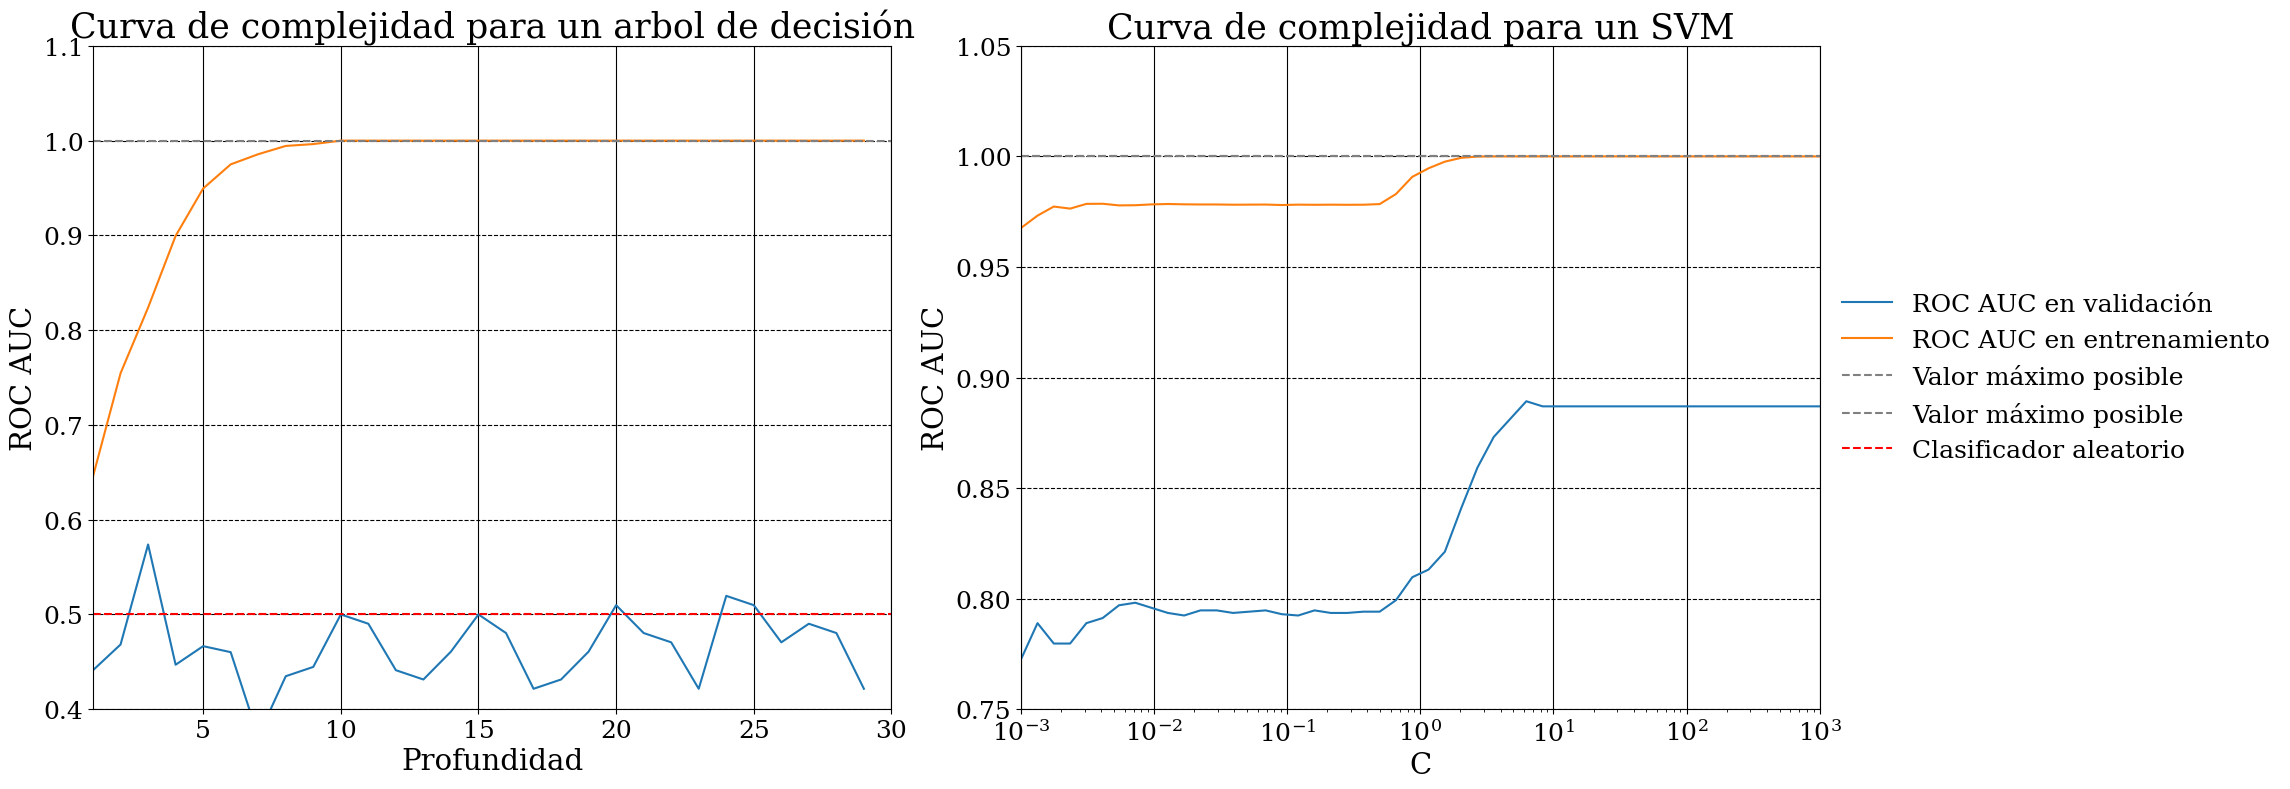

In [34]:
fig, ax = plt.subplots(1, 2, figsize = (23, 8), tight_layout = True)

ax[0].plot(depths, roc_auc_val_dt, label='ROC AUC en validación')
ax[0].plot(depths, roc_auc_train_dt, label='ROC AUC en entrenamiento')
ax[0].set_ylabel("ROC AUC")
ax[0].set_xlabel("Profundidad")
ax[0].grid(ls="--", axis="y")
ax[0].set_title("Curva de complejidad para un arbol de decisión")
ax[0].set_ylim(0.4, 1.1)
ax[0].axhline(1, label='Valor máximo posible', color='gray', ls='--')
ax[0].axhline(0.5, label='Clasificador aleatorio', color='red', ls='--')
#ax[0].legend(loc='center right', framealpha=1, fancybox=False, edgecolor='black')
ax[0].set_xlim(1, 30)

ax[1].plot(C, roc_auc_val_svm, label='ROC AUC en validación')
ax[1].plot(C, roc_auc_train_svm, label='ROC AUC en entrenamiento')
ax[1].set_ylabel("ROC AUC")
ax[1].set_xlabel("C")
ax[1].grid(ls="--", axis="y")
ax[1].set_title("Curva de complejidad para un SVM")
ax[1].set_xscale('log')
ax[1].axhline(1, label='Valor máximo posible', color='gray', ls='--')
ax[1].axhline(1, label='Valor máximo posible', color='gray', ls='--')
ax[1].axhline(0.5, label='Clasificador aleatorio', color='red', ls='--')
ax[1].legend(loc='center left', bbox_to_anchor=(1, 0.5), framealpha=0)
ax[1].set_ylim(0.75, 1.05)
ax[1].set_xlim(C[0], C[-1])

Se observa una tendencia similar en las curvas de complejidad de ambos modelos en el conjunto de entrenamiento. En ambos casos, a partir de cierto valor del hiperparámetro observado, el rendimiento alcanza su máximo valor posible y se estabiliza, lo que sugiere que ambos modelos han sobreajustado los datos de entrenamiento en ese punto.

Por otro lado, las curvas correspondientes al conjunto de validación presentan diferencias significativas. En el caso del árbol de decisión, la curva oscila alrededor de $0.5$, lo que equivale a un clasificador aleatorio. Esto indica que, a medida que aumenta la profundidad, el modelo sufre un mayor overfitting, lo que impide clasificar correctamente los datos de validación. En otras palabras, el modelo incrementa su sesgo y reduce su varianza a costa de no poder generalizar sobre datos no observados.

En cambio, para el modelo SVM, la curva de validación inicialmente se estabiliza cerca de $0.8$. Sin embargo, cuando el valor de $C \leq 1$, la precisión comienza a aumentar hasta alcanzar un nuevo nivel cercano a 0.9. A diferencia del árbol de decisión, el SVM muestra una mejor compensación entre sesgo y varianza, donde un mayor valor de $C$ reduce la varianza del modelo sin aumentar tanto el sesgo como para impedir la mejoría en la clasificación de datos no observados. Sin embargo, a partir de cierto valor de $C$ se estabiliza rendimiento del modelo.

## Ejercicio 4.2: Curvas de aprendizaje

A continuación observamos las curvas de aprendizaje de los dos modelos anteriores y de LDA. Lo hacemos considerando los parámetros óptimos obtenidos en el punto anterior y observando cómo cambia la performance del modelo al considerar más datos en el set de entrenamiento.

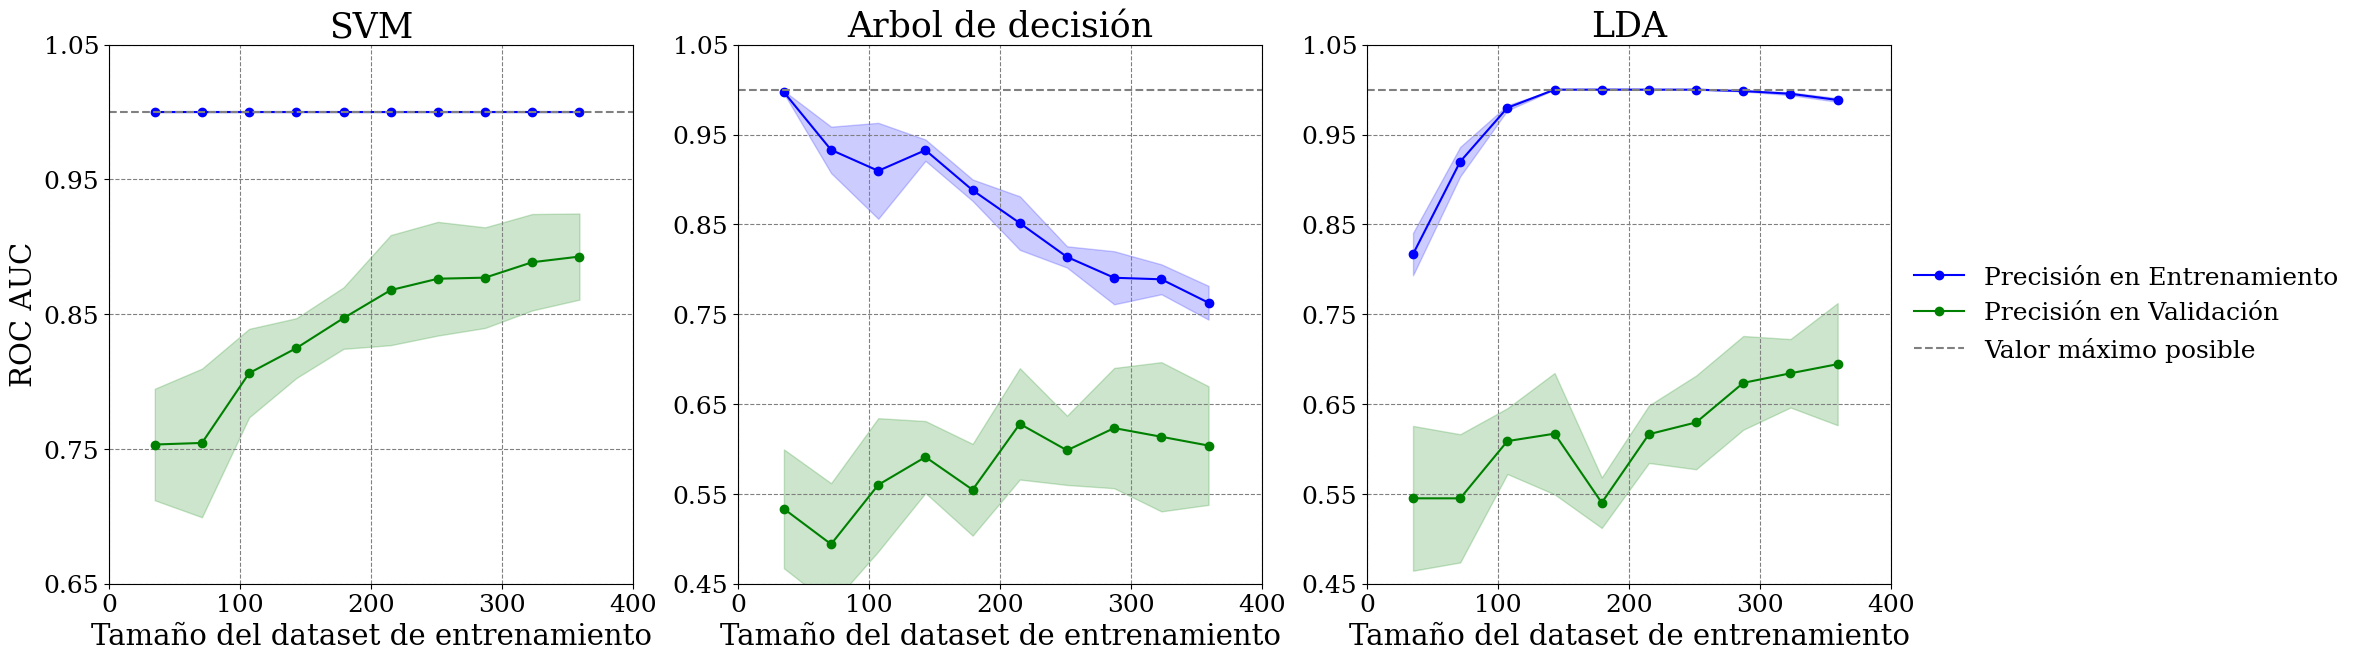

In [35]:
from sklearn.model_selection import learning_curve

def plot_learning_curve(model, ax):

    # Generar las curvas de aprendizaje
    train_sizes, train_scores, test_scores = learning_curve(
        model, X_train, y_train, cv=5, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10), scoring='roc_auc')

    # Calcular promedios y desviaciones estándar
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    # Graficar la curva de aprendizaje
    ax.plot(train_sizes, train_scores_mean, label='Precisión en Entrenamiento', color='blue', marker='o')
    ax.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, color='blue', alpha=0.2)
    ax.plot(train_sizes, test_scores_mean, label='Precisión en Validación', color='green', marker='o')
    ax.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, color='green', alpha=0.2)

fig, ax = plt.subplots(1, 3, figsize=(23, 7))

plot_learning_curve(SVC(C=42, gamma='scale', kernel='rbf', degree=6, probability=True), ax[0])

plot_learning_curve(DecisionTreeClassifier(
    class_weight='balanced',
    criterion='gini',
    max_depth=3,
    max_features=None,
    min_samples_split=5,
    min_impurity_decrease=0.025656278370136378), ax[1])

plot_learning_curve(LinearDiscriminantAnalysis(), ax[2])

ax[0].set_title('SVM')
ax[1].set_title('Arbol de decisión')
ax[2].set_title('LDA')

ax[0].set_xlabel('Tamaño del dataset de entrenamiento')
ax[1].set_xlabel('Tamaño del dataset de entrenamiento')
ax[2].set_xlabel('Tamaño del dataset de entrenamiento')
ax[0].set_ylabel('ROC AUC')

ax[0].set_ylim(0.65, 1.05)
ax[1].set_ylim(0.45, 1.05)
ax[2].set_ylim(0.45, 1.05)

ax[0].set_yticks([0.65, 0.75, 0.85, 0.95, 1.05])
ax[1].set_yticks([0.45, 0.55, 0.65, 0.75, 0.85, 0.95, 1.05])
ax[2].set_yticks([0.45, 0.55, 0.65, 0.75, 0.85, 0.95, 1.05])

ax[0].grid(ls='--', color='gray')
ax[1].grid(ls='--', color='gray')
ax[2].grid(ls='--', color='gray')

ax[0].set_xlim(0, 400)
ax[1].set_xlim(0, 400)
ax[2].set_xlim(0, 400)

ax[0].axhline(1, ls='--', color='gray')
ax[1].axhline(1, ls='--', color='gray')
ax[2].axhline(1, ls='--', color='gray', label='Valor máximo posible')

ax[2].legend(loc='center left', bbox_to_anchor=(1, 0.5), framealpha=0)

plt.show()

Vemos que la tendencia en las curvas de aprendizaje varía para los tres modelos. Sin embargo, en todos los casos podemos afirmar que aumentar el tamaño del dataset de entrenamiento mejora la capacidad predictiva del modelo, ya que a mayor tamaño del set de entrenamiento, mayor es la precisión en el set de validación.

Para el SVM, se observa que incluso con pocos datos, la precisión en el set de entrenamiento es muy alta y se mantiene en su valor máximo independientemente del tamaño del set. Esto contrasta con el árbol de decisión, donde la precisión del entrenamiento disminuye a medida que aumenta el tamaño del dataset, lo que sugiere que el sesgo del modelo se reduce con más muestras. Finalmente, en el caso del LDA, notamos que la precisión en el set de entrenamiento se estabiliza en su valor máximo alrededor de las $150$ instancias, aunque disminuye ligeramente al alcanzar las $350$. A pesar de esta leve disminución, la alta precisión no genera un sesgo que impida mejorar la precisión en el set de validación, sino todo lo contrario.

Concluimos que, en todos los casos, aumentar el set de entrenamiento es beneficioso, ya que ayuda a mejorar la precisión en el set de validación. Sin embargo, en el caso del árbol de decisión, es importante aclarar que no sería conveniente seguir aumentando el tamaño del dataset si esto provoca que la disminución de la precisión en el set de entrenamiento continue, ya que podría conducir a un caso de underfitting.

## 4.3: Entrenamiento de Random Forest

A continuación con un randomized search buscamos los parámetros óptimos de un modelo _RandomForest_ con 200 árboles.

In [36]:
from sklearn.ensemble import RandomForestClassifier

param_grid = {
    'max_depth': randint(1, 30),
    'criterion': ['gini', 'entropy'],
    'max_features': uniform(0, 1),
}

random_search_rf = RandomizedSearchCV(RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1), 
                   param_distributions=param_grid,
                   n_iter=10,
                   n_jobs=-1,
                   cv=5,
                   random_state=42,
                   scoring='roc_auc'
                   )

random_search_rf.fit(X_train, y_train)

best_params_rf = random_search_rf.best_params_
best_score_rf = random_search_rf.best_score_

print(best_params_rf)
print(best_score_rf)

{'criterion': 'entropy', 'max_depth': 21, 'max_features': 0.6174815096277165}
0.8062651171022359


A continuación generamos la curva de complejidad del modelo modificando el valor de _max_features_  usando el resto de los parámetros obtenidos en el punto anterior.

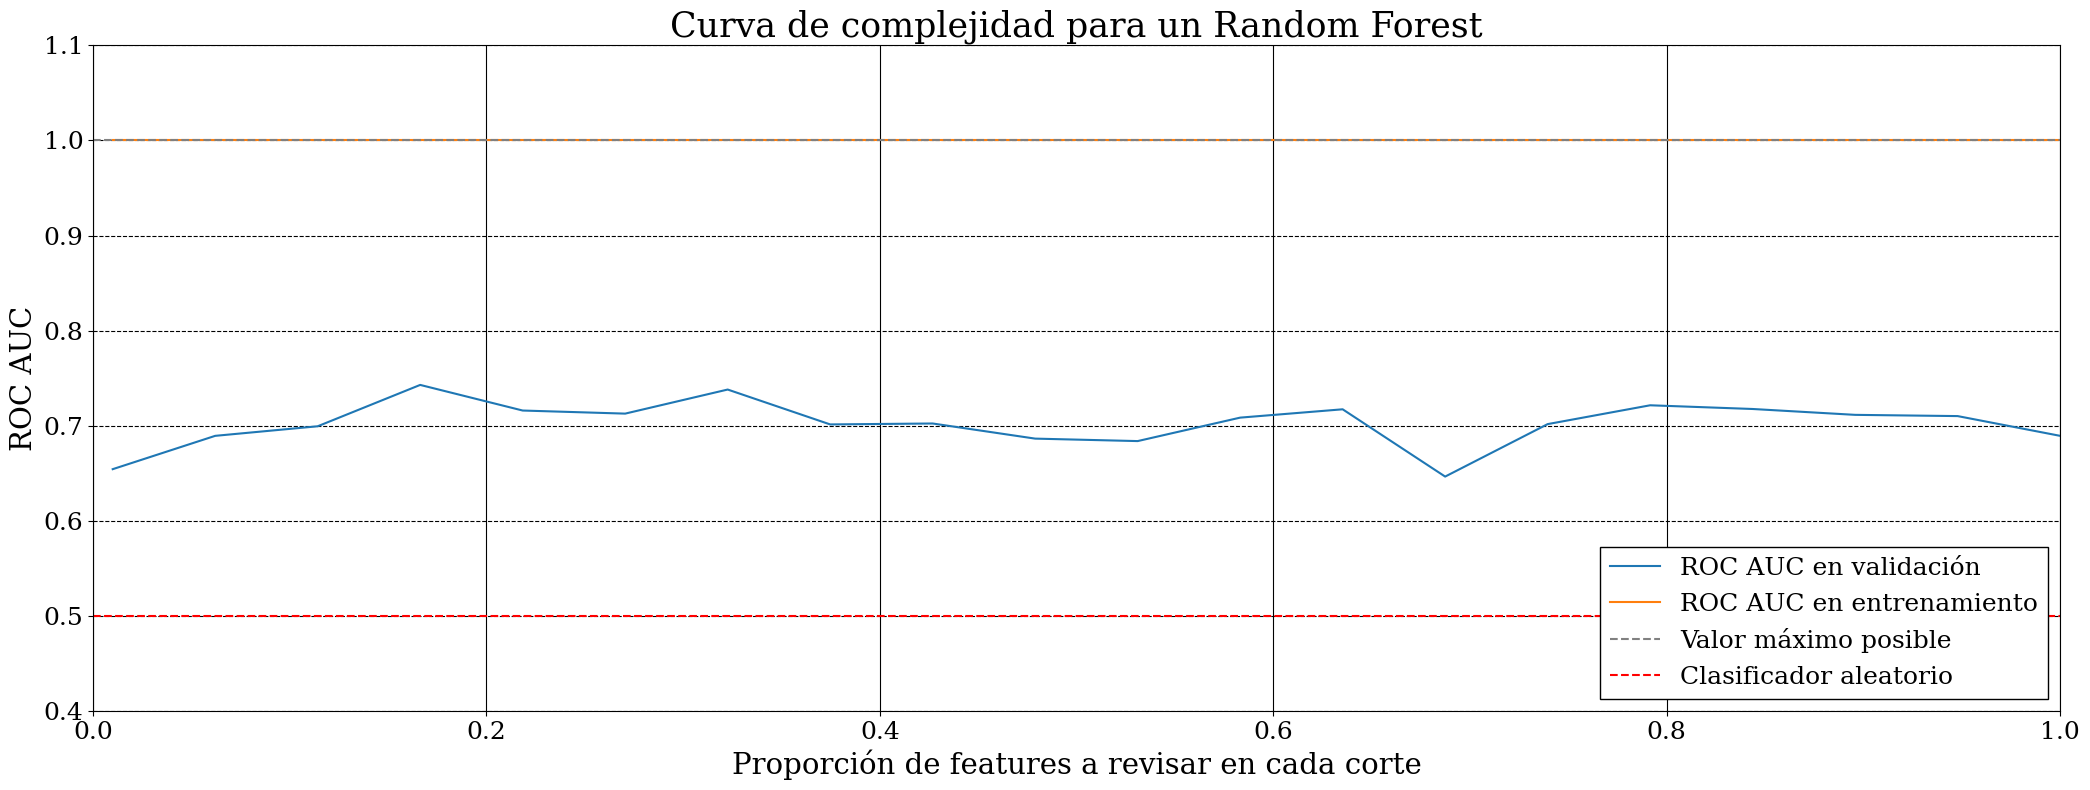

In [43]:
X_train_curve, X_val_curve, y_train_curve, y_val_curve = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train, random_state=43)

def train_random_forest(max_features: int):
    model = RandomForestClassifier(max_depth=21, 
                                   max_features=max_features,
                                   n_estimators=200,
                                   criterion='entropy',
                                   n_jobs=-1)

    model.fit(X_train_curve, y_train_curve)
    return model

def experiment(train_model_func, params):

    roc_auc_val, roc_auc_train = [], []
    for i in params:
        
        model = train_model_func(i)
        
        roc_auc_val.append(
            roc_auc_score(y_val_curve, model.predict_proba(X_val_curve)[:, 1])
        )

        roc_auc_train.append(
            roc_auc_score(y_train_curve, model.predict_proba(X_train_curve)[:, 1])
        ) 

    return roc_auc_train, roc_auc_val

max_features = np.linspace(0.01, 1, 20)
train_roc_auc, val_roc_auc = experiment(train_random_forest, max_features)

fig, ax = plt.subplots(1, 1, tight_layout=True)

ax.plot(max_features, val_roc_auc, label='ROC AUC en validación')
ax.plot(max_features, train_roc_auc, label='ROC AUC en entrenamiento')
ax.set_ylabel("ROC AUC")
ax.set_xlabel("Proporción de features a revisar en cada corte")
ax.grid(ls="--", axis="y")
ax.set_title("Curva de complejidad para un Random Forest")
ax.set_ylim(0.4, 1.1)
ax.axhline(1, label='Valor máximo posible', color='gray', ls='--')
ax.axhline(0.5, label='Clasificador aleatorio', color='red', ls='--')
ax.set_xlim(0, 1)
ax.legend(loc='lower right', fancybox=False, edgecolor='black', framealpha=1)
plt.show()

Podemos ver que para distintas proporciones de _features_ a considerar para hacer un split el valor de AUC-ROC oscila alrededor de $0.7$. Este comportamiento es similar al que vimos para un único árbol de decisión al cambiar la profundidad, donde esta vez el modelo no oscila alrededor del $0.5$. En un principio esto indicaría que no hay diferencias significativas entre hacer un Bagged Ensemble de árboles de desición (con reposición) y considerar un random forest con baja proporción de features. Consecuentemente esto puede significar que el número de _features_ correlacionadas no es lo suficientemente fuerte, y que tampoco lo es la intensidad de esa correlación. 

A continuación hacemos la prueba trivial de comprobar que el comportamiento de la curva de complejidad de un Bagging Classifier modificando la proporción de _max_features_ es igual al del Random Forest anterior.

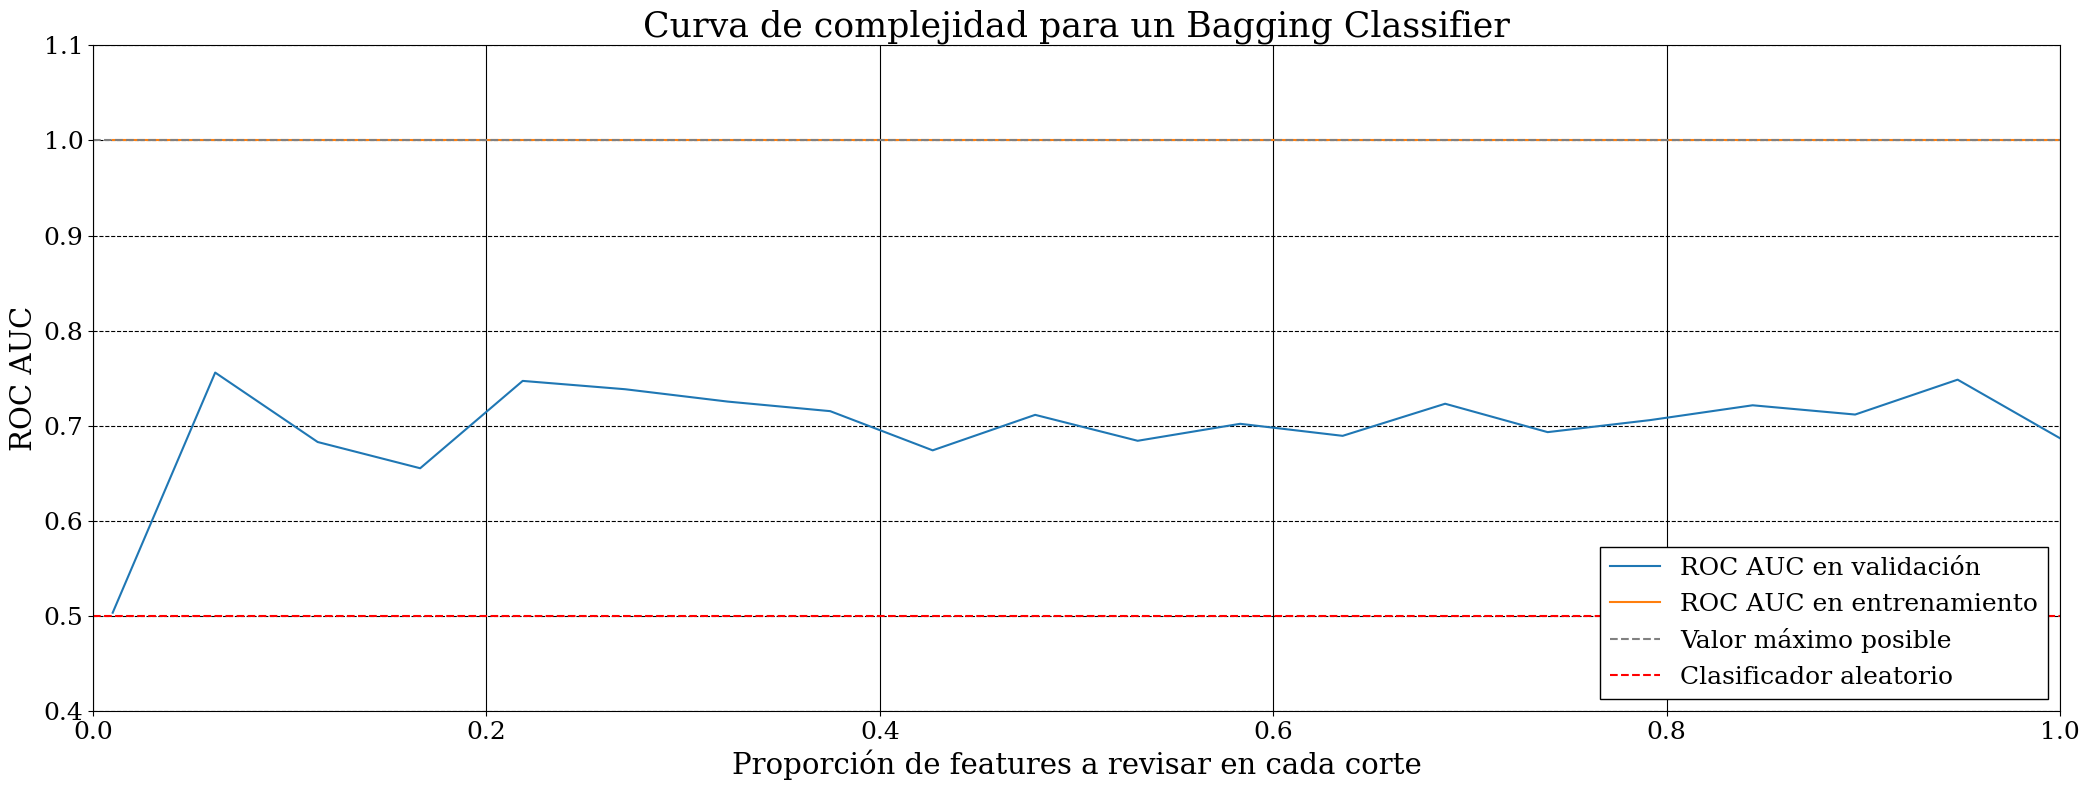

In [44]:
from sklearn.ensemble import BaggingClassifier

def train_random_forest(max_features: int):
    model = BaggingClassifier(estimator = DecisionTreeClassifier(max_depth=21, criterion='entropy'),
                                   max_features=max_features,
                                   n_estimators=200,
                                   n_jobs=-1)

    model.fit(X_train_curve, y_train_curve)
    return model

def experiment(train_model_func, params):

    roc_auc_val, roc_auc_train = [], []
    for i in params:
        
        model = train_model_func(i)
        
        roc_auc_val.append(
            roc_auc_score(y_val_curve, model.predict_proba(X_val_curve)[:, 1])
        )

        roc_auc_train.append(
            roc_auc_score(y_train_curve, model.predict_proba(X_train_curve)[:, 1])
        ) 

    return roc_auc_train, roc_auc_val

max_features = np.linspace(0.01, 1, 20)
train_roc_auc, val_roc_auc = experiment(train_random_forest, max_features)

fig, ax = plt.subplots(1, 1, tight_layout=True)

ax.plot(max_features, val_roc_auc, label='ROC AUC en validación')
ax.plot(max_features, train_roc_auc, label='ROC AUC en entrenamiento')
ax.set_ylabel("ROC AUC")
ax.set_xlabel("Proporción de features a revisar en cada corte")
ax.grid(ls="--", axis="y")
ax.set_title("Curva de complejidad para un Bagging Classifier")
ax.set_ylim(0.4, 1.1)
ax.axhline(1, label='Valor máximo posible', color='gray', ls='--')
ax.axhline(0.5, label='Clasificador aleatorio', color='red', ls='--')
ax.set_xlim(0, 1)
ax.legend(loc='lower right', fancybox=False, edgecolor='black', framealpha=1)
plt.show()

lo que dice en sklearn: 

max_featuresint or float, default=1.0
The number of features to draw from X to train each base estimator ( without replacement by default, see bootstrap_features for more details).



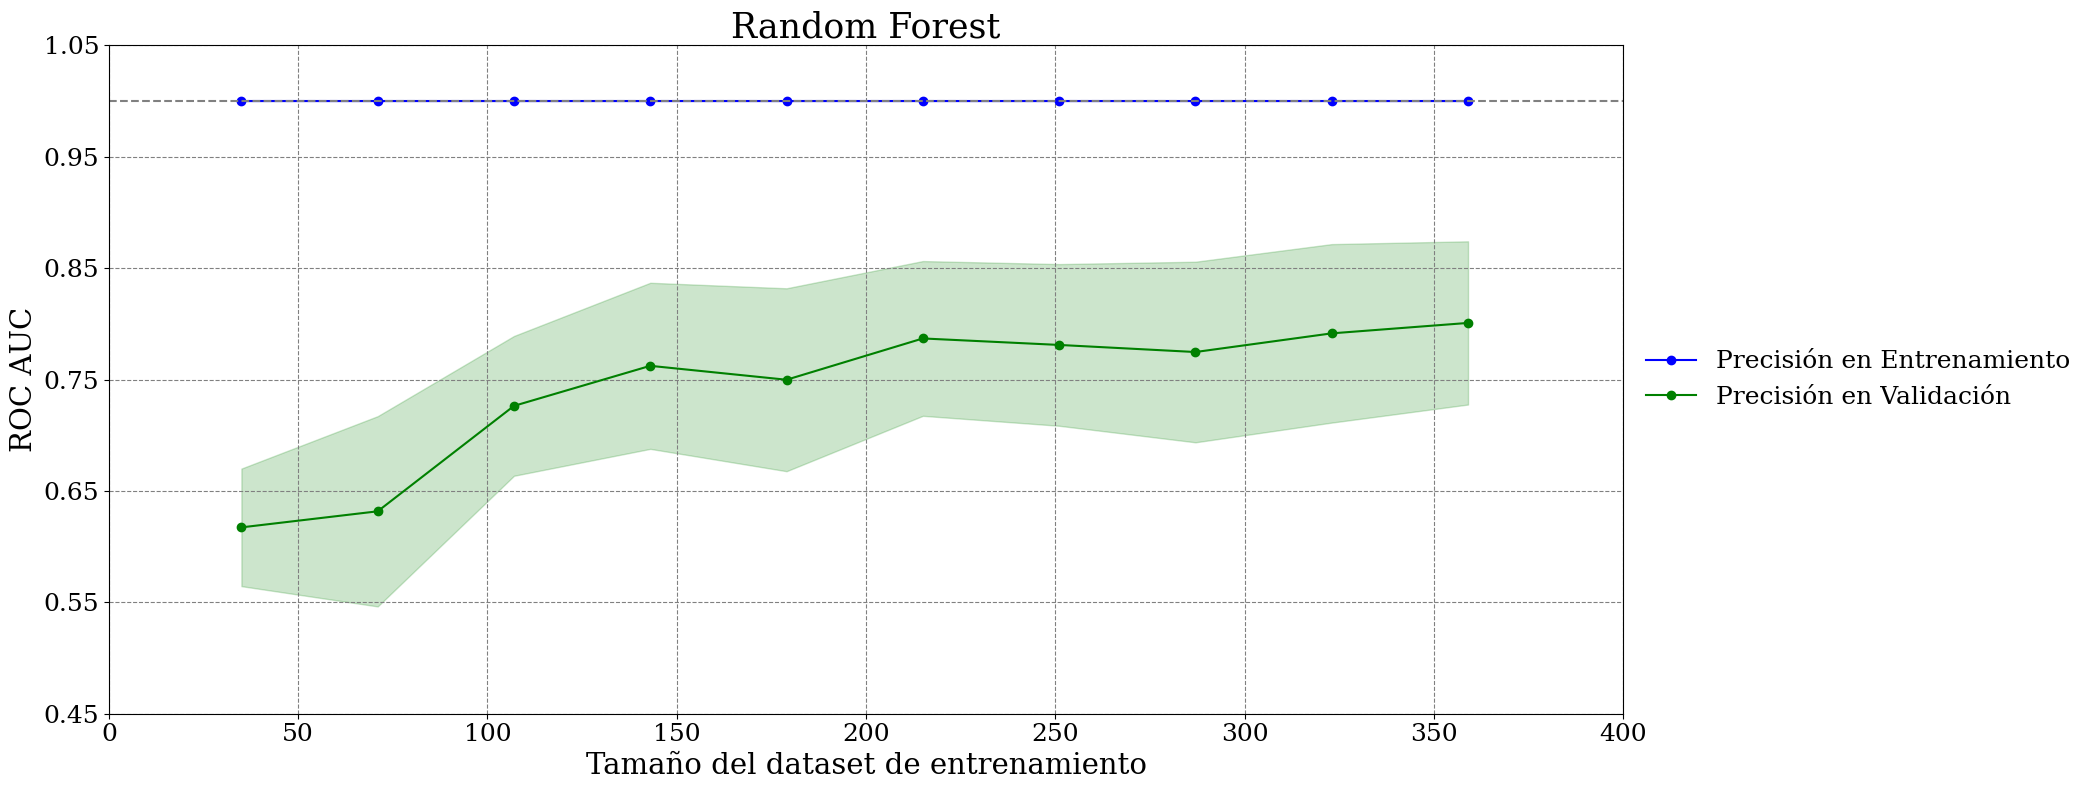

In [41]:
fig, ax = plt.subplots(1, 1, tight_layout = True)

plot_learning_curve(RandomForestClassifier(criterion='entropy', max_depth=21, max_features=0.6174815096277165), ax)

ax.set_title('Random Forest')
ax.set_xlabel('Tamaño del dataset de entrenamiento')
ax.set_ylabel('ROC AUC')
ax.set_ylim(0.45, 1.05)
ax.set_yticks([0.45, 0.55, 0.65, 0.75, 0.85, 0.95, 1.05])
ax.grid(ls='--', color='gray')
ax.set_xlim(0, 400)
ax.axhline(1, ls='--', color='gray')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), framealpha=0)

plt.show()

Finalmente observamos que un Random Forest que usa los hiperparámetros óptimos encontrados anteriormente, tener un mayor dataset de entrenamiento mejora su capacidad de clasificación.

# Ejercicio 5

### Predecimos los resultados de un held-out y estimamos el score que nos dará AUC-ROC

A continuación usando el mejor modelo encontrado (SVM) con sus hiperparámetros óptimos, entrenandolo con todo el dataset encontramos los valores que se predicen para un nuevo dataset nunca antes visto.

In [5]:
df_held_out = pd.read_csv("X_held_out.csv")
df_held_out

,IMzq,NuAg,FpJw,vilF,AKmi,BDfC,pDDY,znPg,VNds,eCei,...,Vthd,kcQL,OHJK,zbGt,XzTy,uauW,xbpG,Nozi,jRec,MngL
0,1.176255,-0.369854,-0.030389,-1.829193,-0.881688,0.207044,1.886385,-4.298481,-1.267532,-4.099848,...,0.524601,1.699602,-3.367273,-1.582250,0.130206,1.311595,-11.215114,-2.498074,1.014487,3.083070
1,0.297178,1.863728,-1.463056,-0.609392,-0.290330,0.603847,1.627391,1.344054,-0.162206,-4.721570,...,0.801667,0.402345,-4.364047,-1.158949,-0.918005,-0.014512,-10.830159,-2.345360,0.460640,-13.552176
2,0.594759,0.555020,0.463382,0.921239,-1.985320,-0.663167,-0.948119,0.027963,0.422866,-1.223708,...,0.047150,-0.439831,-2.146637,1.635017,2.076103,0.106253,14.561139,3.073056,-0.282929,-2.929982
3,-5.061619,0.028435,-0.064818,0.711717,-1.045748,0.046408,5.722633,-4.831901,0.775052,-2.555266,...,0.734159,4.115613,1.922497,-0.098387,0.907363,-0.638313,18.211837,3.388264,0.255810,16.907270
4,-1.686206,-0.876991,-0.016341,-0.775191,-0.920186,1.880892,4.511061,5.796727,-0.536220,-0.141581,...,1.291235,-2.590899,-3.678021,1.963310,-2.586972,-1.749036,10.945732,-3.365048,-0.883741,-19.387977
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245,0.957572,2.422849,0.851528,-1.373839,0.315485,2.795033,-1.374487,1.304370,1.442854,-10.113535,...,-1.247259,1.897692,-2.155833,1.144701,-0.452444,-0.387505,-7.425584,1.164834,0.051714,17.923270
246,-0.637837,0.587543,-0.100994,-0.689454,-0.469908,-0.442153,-5.065167,-1.402005,-0.487008,1.282978,...,-0.630556,-3.431041,-1.199669,1.913785,-0.377974,-0.732129,7.186597,1.444040,-0.483373,14.893442
247,1.214833,0.341982,1.029563,1.560634,0.453776,0.168084,-5.451699,-9.049856,0.212636,-0.434326,...,-1.271707,-0.399035,7.462911,1.204197,-1.818874,0.638688,19.647561,-0.316413,-0.191266,21.671858
248,-6.518768,-0.260236,0.941625,0.011947,1.117625,-1.305716,3.240383,-2.810109,1.018003,1.572321,...,0.797311,3.453622,3.851956,0.099671,-1.013486,-0.157724,-25.080124,-3.742114,0.706801,-7.256825


In [16]:
y = df['target']
X = df.drop(columns='target')

In [17]:
from sklearn.svm import SVC

svc_param_grid = {
    "svm__C": loguniform(1e-8, 1e4, 1),
    'svm__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    "svm__degree": [2, 3, 5, 6],
    "svm__gamma": ['scale', 'auto'],

}

pipeline = Pipeline([
    #('scaler', StandardScaler()),
    ('svm', SVC())
])

best_model, model_params, best_score = experiment(X, y, pipeline, svc_param_grid)

print(f'Best model params: {model_params}')
print('Best score (Mean Validation ROC AUC)', best_score)

Fitting 5 folds for each of 500 candidates, totalling 2500 fits
Best model params: {'svm__C': 2.4392537139193866, 'svm__degree': 5, 'svm__gamma': 'scale', 'svm__kernel': 'rbf'}
Best score (Mean Validation ROC AUC) 0.9039728898128898


In [18]:
#Consideramos los parámetros óptimos del modelo con todo el dataset
model = SVC(C=2.4392537139193866, gamma='scale', kernel='rbf', degree=5, probability=True)

#fiteamos esta vez con todo el dataset
model.fit(X=X, y=y)

SVC(C=2.4392537139193866, degree=5, probability=True)

In [19]:
y = model.predict(df_held_out)
y_proba = model.predict_proba(df_held_out)

# Ejercicio 6: Conclusiones